## Comments on Filtering 

Consider a reference sequence, length $L$, and a pool of other sequences to compare with. In a genome, there are $N \approx 4\times 10^6$ other sequences to compare with the reference. 
\begin{align*}
    L \text{ choose } n &\text{ number of combinations}\\
    (1/4)^{L - n}(3/4)^n &\text{ probabilty a combination is observed}
\end{align*}
Hence we define the following $E(n, L)$, which is the number of sequences expected to have $n$ differences, given a query length $L$. 
$$
E(n, L) = N \bigg(\frac{(L \text{ choose }n)3^n}{4^L} \bigg)
$$
We want to filter so that $E(n, L)$ is less than a threshold, $\tau = 0.1$. 

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import entropy


In [ ]:
import pandas as pd

NT_MAP = {c: i for i, c in enumerate(['A', 'C', 'G', 'T'])}

GENE = 'rspA'

search = pd.read_csv('../data/search.csv')


index = search[search['gene'] == GENE].index

query = search['start'].loc[index].tolist()[0]


tau = 0.1 #threshold
N = 4*10**6 #genome length
L = len(query) #query length
m = 85 #number of genome files
seq_len = 175 #sequence length

seqs = []

print(L)
def E(n, L):
    comb = math.comb(L, n)
    return N*(comb*3**n/4**L)


for j in range(m):
    print(j)
    FPATH = f'../results/multiquery_results_0_30/results_{j}.tsv.gz'
    results = pd.read_csv(FPATH, sep='\t')
    indices = results[results['query_string'] == query].index.tolist()
    for i in indices: 
        if E(int(results['min_distance'][i]), L) < tau: # and results['min_distance'][i] != 0:
            sequence = results['contig_segments'][i]
            numeric_sequence = [NT_MAP[c.upper()] for c in sequence if c.upper() in ['A', 'C', 'T', 'G']]
            if len(numeric_sequence) == seq_len:  
                seqs.append(numeric_sequence[5:165])
        

30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


43767


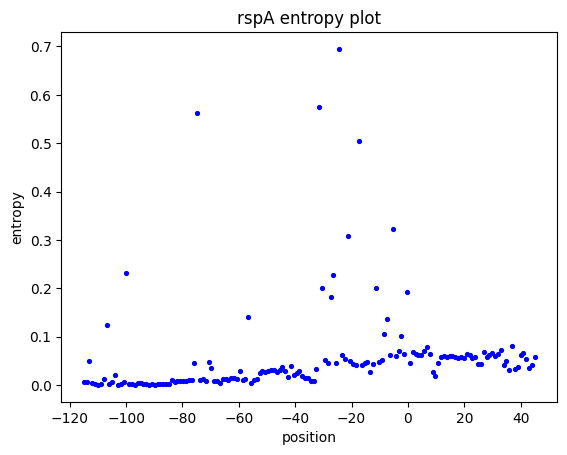

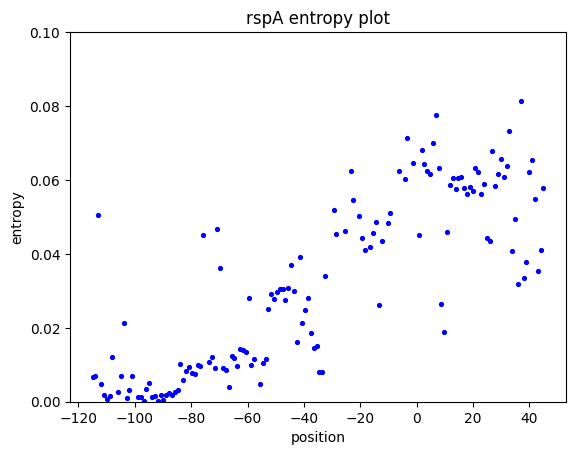

In [ ]:

print(len(seqs))

def calculate_entropy(seqs):
    seqs = np.array(seqs)
    num_seqs, seq_length = seqs.shape
    entropies = np.zeros(seq_length)
    for i in range(seq_length):
        values, counts = np.unique(seqs[:, i], return_counts=True)
        entropies[i] = entropy(counts)
    return entropies


entropies = calculate_entropy(seqs)
        
x = np.linspace(-115, 45, 160)    
plt.scatter(x, entropies, s = 7.5, color = 'blue', label = 'entropy')

#binding_sites = [(-70, -60), (-45, -20)]
#for start, end in binding_sites:
#    plt.axvspan(start, end, color='yellow', alpha=0.3)

#plt.ylim(0,0.1)
plt.xlabel('position')
plt.ylabel('entropy')
plt.title(f'{GENE} entropy plot')
plt.savefig(f'../out/entropy_plots/{GENE}_full.png')
plt.show()
plt.scatter(x, entropies, s = 7.5, color = 'blue', label = 'entropy')

#binding_sites = [(-70, -60), (-45, -20)]
#for start, end in binding_sites:
#    plt.axvspan(start, end, color='yellow', alpha=0.3)

plt.ylim(0,0.1)
plt.xlabel('position')
plt.ylabel('entropy')
plt.title(f'{GENE} entropy plot')
plt.savefig(f'../out/entropy_plots/{GENE}_capped.png')

In [165]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pandas as pd

from entropies import produce_seqs, plot_entropies 

GENE = 'rspA'

seqs = produce_seqs(GENE)

plot_entropies(seqs, GENE)






ImportError: cannot import name 'produce_seqs' from 'entropies' (/Users/joelandsittel/Documents/Promoter_Dissection/natvar/notebooks/../natvar/entropies.py)